In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Python modules

In [2]:
import itertools
from os import path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Utility to plot confusion matrix.

In [3]:
## Read dataimport itertools  # (compatibility)
from sklearn.metrics import confusion_matrix  # (compatibility)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    - Robust to suspected bug in matplotlib==3.1.1.
    - Backward-compatible (signature as original implementation).
    """
    
    class ConfusionMatrixDisplay:

        def __init__(self, confusion_matrix, display_labels):
            self.confusion_matrix = confusion_matrix
            self.display_labels = display_labels

        def plot(self, include_values=True, cmap='viridis',
                 xticks_rotation='horizontal', values_format=None, ax=None):
            import matplotlib.pyplot as plt

            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.figure

            cm = self.confusion_matrix
            n_classes = cm.shape[0]
            self.im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
            self.text_ = None

            cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(256)

            if include_values:
                self.text_ = np.empty_like(cm, dtype=object)
                if values_format is None:
                    values_format = '.2g'

                # print text with appropriate color depending on background
                thresh = (cm.max() + cm.min()) / 2.0
                for i, j in itertools.product(range(n_classes), range(n_classes)):
                    color = cmap_max if cm[i, j] < thresh else cmap_min
                    self.text_[i, j] = ax.text(j, i,
                                               format(cm[i, j], values_format),
                                               ha="center", va="center",
                                               color=color)

            fig.colorbar(self.im_, ax=ax)
            ax.set(xticks=np.arange(n_classes),
                   yticks=np.arange(n_classes),
                   xticklabels=self.display_labels,
                   yticklabels=self.display_labels,
                   ylabel="True label",
                   xlabel="Predicted label")

            ax.set_ylim((n_classes - 0.5, -0.5))
            plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)

            self.figure_ = fig
            self.ax_ = ax
            return self

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=classes
    )
    disp.plot(
        include_values=True,
        cmap=cmap, ax=None,
        xticks_rotation=45,
        values_format="d"
    )    

## Read data

In [4]:
asthma_dat = pd.read_csv("data/asthma_final.csv")

In [5]:
asthma_dat.shape

(12233, 16)

In [6]:
asthma_dat.head()

,Asthma_ED_Admission_Flag,Rhinitis_Diag,Seasonal_Rhinitis_Diag,Chronic_Bronchitis_diag,Race_Black,Race_Hispanic,Race_Native,Sex_Male,High_Poverty,Moderate_Air,Unstable_Air,Food_Allergies,Environment_allergies,Fluticasone_Drug,Albuterol_Drug,High_Follow-Up_Asthma_Visits
0,0,0,0,0,0,0,0,0,0.0,1,0,1.0,1.0,1,1,0
1,0,0,0,0,0,0,0,1,0.0,1,0,0.0,0.0,1,1,0
2,0,1,0,0,0,0,0,0,0.0,1,0,1.0,1.0,0,0,0
3,0,1,0,0,0,0,0,1,0.0,1,0,0.0,1.0,0,0,0
4,0,1,0,0,0,0,0,1,1.0,1,0,1.0,1.0,0,0,0


## Create dataframes for model

Split data into X and y.

In [8]:
X = asthma_dat.drop("Asthma_ED_Admission_Flag", axis=1)
y = asthma_dat["Asthma_ED_Admission_Flag"]

In [9]:
y.value_counts()

0    9150
1    3083
Name: Asthma_ED_Admission_Flag, dtype: int64

Split data into training and test set.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1,
    test_size=0.3
)

Make a scaled version of the predictors for later use.

In [11]:
scaler = StandardScaler()
scaler_fit = scaler.fit(X_train)
X_train_scaled = scaler_fit.transform(X_train)
X_test_scaled = scaler_fit.transform(X_test)

Cross-validation object.

In [12]:
# cross-validation object
k_fold = KFold(random_state=1, shuffle=True)

## Regularized logistic regression

In [13]:
# logistic pipeline
logistic_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0)
)

# grid for parameter search
param_grid = np.logspace(-3, 0, 100)

# grid search object
grid_search = GridSearchCV(
    logistic_pipeline,
    dict(logisticregression__C=param_grid),
    cv=k_fold
)

# fit model via cross-validation
grid_search_fit = grid_search.fit(X_train, y_train)

# best parameter
best_logistic_C = grid_search_fit.best_params_.get("logisticregression__C")

In [14]:
best_logistic_C

0.024770763559917114

Fit best model to scaled training data.

In [15]:
best_logistic = LogisticRegression(C=best_logistic_C, random_state=0)
best_logistic_fit = best_logistic.fit(X_train_scaled, y_train)

Check performance on test data.

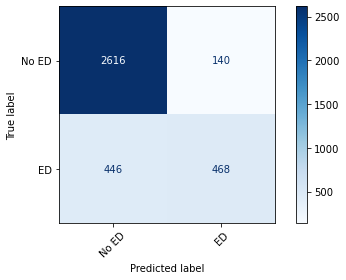

In [16]:
plot_confusion_matrix(
    confusion_matrix(y_test, best_logistic_fit.predict(X_test_scaled)),
    ["No ED", "ED"]
)

plt.tight_layout()


In [17]:
accuracy_score(y_test, best_logistic_fit.predict(X_test_scaled))

0.8403269754768392

In [18]:
precision_score(y_test, best_logistic_fit.predict(X_test_scaled))

0.7697368421052632

In [19]:
recall_score(y_test, best_logistic_fit.predict(X_test_scaled))

0.5120350109409191